In [9]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.utils import class_weight

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
def get_data():
    try:
        X = np.load("data_valence_physio_for_cnn.npy")
        Y = np.load("data_valence_label_for_cnn.npy")
        return X, Y
    except:
        print "No stored files found.. load from files first"

In [3]:
X, Y = get_data()
print X.shape
print Y.shape

(402, 800, 24)
(402, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ab316ced0>]],
      dtype=object)

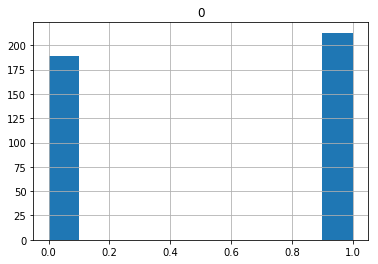

In [4]:
# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
pd.DataFrame(Y).hist()

In [5]:
# compute class weight
cw = class_weight.compute_class_weight('balanced', np.unique(Y), Y.flatten())
print cw

[1.06349206 0.94366197]


In [14]:
batch_size = X.shape[0]
data_dim = X.shape[2]
timesteps = X.shape[1]

n_classes = Y.shape[1]

hidden_size = 24
n_epochs = 10
n_splits = 10
fixed_batch_size = (batch_size - batch_size/n_splits) - 1

print batch_size
print fixed_batch_size
print data_dim
print timesteps

402
361
24
800


# Model LSTM

In [16]:
def create_model():
    model = Sequential()
    
    batch_input_shape = (fixed_batch_size, timesteps, data_dim)
    
    model.add(LSTM(hidden_size, return_sequences=True, stateful=True, batch_input_shape=batch_input_shape))
    model.add(LSTM(n_classes))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [17]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=n_epochs, batch_size=fixed_batch_size, verbose=0)

# evaluate using 10-fold cross validation
cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
results = cross_val_score(model, X, Y, cv=cv, verbose=1)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


InvalidArgumentError: Incompatible shapes: [41,24] vs. [361,24]
	 [[{{node lstm_7/while/add_5}}]]

# Model Time distributed LSTM

In [31]:
model_1 = Sequential()
model_1.add(LSTM(hidden_size, return_sequences=True, stateful=True, batch_input_shape=(batch_size, timesteps, data_dim)))
model_1.add(Dropout(rate=1-0.5))
model_1.add(LSTM(hidden_size, return_sequences=True))
model_1.add(Dropout(rate=1-0.5))
model_1.add(LSTM(hidden_size))
model_1.add(Dropout(rate=1-0.5))
model_1.add(Dense(n_classes, activation='softmax'))
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (89, 1500, 24)            4704      
_________________________________________________________________
dropout_22 (Dropout)         (89, 1500, 24)            0         
_________________________________________________________________
lstm_27 (LSTM)               (89, 1500, 24)            4704      
_________________________________________________________________
dropout_23 (Dropout)         (89, 1500, 24)            0         
_________________________________________________________________
lstm_28 (LSTM)               (89, 24)                  4704      
_________________________________________________________________
dropout_24 (Dropout)         (89, 24)                  0         
_________________________________________________________________
dense_10 (Dense)             (89, 1)                   25        
Total para

In [32]:
model_1.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=False, sample_weight=sample_weight_train)

Epoch 1/10
89/89 [==============================] - 6s 67ms/step - loss: 7.9712 - acc: 0.2697
Epoch 2/10
89/89 [==============================] - 2s 23ms/step - loss: 7.9712 - acc: 0.2697
Epoch 3/10
89/89 [==============================] - 2s 23ms/step - loss: 7.9712 - acc: 0.2697
Epoch 4/10
89/89 [==============================] - 2s 23ms/step - loss: 7.9712 - acc: 0.2697
Epoch 5/10
89/89 [==============================] - 2s 22ms/step - loss: 7.9712 - acc: 0.2697
Epoch 6/10
89/89 [==============================] - 2s 23ms/step - loss: 7.9712 - acc: 0.2697
Epoch 7/10
89/89 [==============================] - 2s 22ms/step - loss: 7.9712 - acc: 0.2697
Epoch 8/10
89/89 [==============================] - 2s 23ms/step - loss: 7.9712 - acc: 0.2697
Epoch 9/10
89/89 [==============================] - 2s 23ms/step - loss: 7.9712 - acc: 0.2697
Epoch 10/10
89/89 [==============================] - 2s 22ms/step - loss: 7.9712 - acc: 0.2697


In [ ]:
model_1.evaluate(x_valid, y_valid, batch_size=1)